### Import

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
import pandas as pd
import ast
import pickle
from itertools import combinations

### Utils

In [3]:
def parse_abs_text(text: str) -> dict:
    """
    Parse le contenu d'un fichier .abs (meta arXiv) et renvoie un dict
    avec les principaux champs.
    """
    rec = {
        "paper_id": None,
        "from_field": None,
        "date": None,
        "title": None,
        "authors_raw": None,
        "subj_class": None,
        "journal_ref": None,
        "comments": None,
    }

    for line in text.splitlines():
        line = line.rstrip()

        if line.startswith("Paper:"):
            # ex: "Paper: hep-th/9201001"
            rec["paper_id"] = line.split(":", 1)[1].strip()

        elif line.startswith("From:"):
            rec["from_field"] = line.split(":", 1)[1].strip()

        elif line.startswith("Date:"):
            rec["date"] = line.split(":", 1)[1].strip()

        elif line.startswith("Title:"):
            rec["title"] = line.split(":", 1)[1].strip()

        elif line.startswith("Authors:"):
            authors = line.split(":", 1)[1].strip()
            rec["authors_raw"] = authors

        elif line.startswith("Comments:"):
            rec["comments"] = line.split(":", 1)[1].strip()

        elif line.startswith("Subj-class:"):
            rec["subj_class"] = line.split(":", 1)[1].strip()

        elif line.startswith("Journal-ref:"):
            rec["journal_ref"] = line.split(":", 1)[1].strip()

    return rec




<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

# CA-HepTh Dataset — Summary

**What it is**

The CA-HepTh dataset is a **collaboration network** of authors in the *High Energy Physics – Theory* (hep-th) category on **arXiv**.  
It covers submissions from **January 1993 to April 2003** and is provided in two separate parts:

1. A file describing **author–author collaborations**:
   - Each **node = an anonymous author ID**
   - Each **edge = at least one co-authored paper** (undirected)
   - Network scale: **9,877 nodes** and **51,971 edges**

2. A set of per-paper metadata files:
   - One text file per paper (by year)
   - Containing the **abstract**, **submission date**, **author names**, **email of the sender**, etc.
   - Total: **29,555 metadata files**

The goal of this notebook is to reconstruct an **interpretable author collaboration network** from the metadata, and to compare it with the original SNAP collaboration graph.

**Why it matters**

- The dataset is widely used to study **real-world network properties**:
  - degree distribution
  - clustering and small-world effects
  - community formation and evolution
- It is frequently referenced in network science (e.g. Newman, *PNAS*, 2001) as a benchmark for **scientific collaboration graphs**.

## Why I chose it

- It connects data analysis with **theoretical physics**, a field I genuinely enjoy.
- The dataset reflects **real scientific relationships**, rather than synthetic or toy graphs.
- It is a good playground to explore how physicists collaborate and how knowledge propagates through a scientific community.

**Source:** Stanford SNAP — https://snap.stanford.edu/data/ca-HepTh.html

</div>


## Load metadata and clean them

The original SNAP dataset is split into two independent parts:

- A file describing **collaborations between anonymous author IDs** (e.g. `24325 24394`)
- A folder structure `paper_meta_info/<year>/...` with one file per paper, containing:
  - the **abstract**
  - the **submission date**
  - the **names of the authors**
  - sometimes the **email** of the corresponding author
  - various comments and journal references

However, there is **no mapping file** that links the anonymous `author_id` used in the CA-HepTh graph to the paper identifiers.  
Therefore, the two parts are **not directly joinable**. In this notebook, we reconstruct our own author collaboration network from the paper metadata only, using cleaned author names as node identifiers.


### Cleaning the author part

In [4]:
# path = "CA-HepTh.txt"

# meta_root = Path("paper_meta_info")

# records = []

# for abs_path in meta_root.rglob("*.abs"):
#     # year = nom du dossier parent (1992, 1993, etc.)
#     year = abs_path.parent.name

#     with open(abs_path, encoding="latin-1") as f:
#         text = f.read()

#     rec = parse_abs_text(text)
#     rec["year"] = int(year)
#     rec["file_path"] = str(abs_path)

#     records.append(rec)

# meta_df = pd.DataFrame(records)

# print("Nombre de métadonnées chargées :", len(meta_df))
# meta_df.head()

# def clean_paper_id(pid):
#     if pd.isna(pid) or pid is None:
#         return None
#     # Extract only the numeric part after the slash
#     if '/' in pid:
#         return pid.split('/')[-1]
#     return pid

# meta_df["paper_id"] = meta_df["paper_id"].apply(clean_paper_id)


# def split_authors(raw):
#     if pd.isna(raw):
#         return []
    
#     txt = raw.replace(" and ", ",")
#     parts = [a.strip() for a in txt.split(",")]
#     return [p for p in parts if p]

# meta_df["authors_list"] = meta_df["authors_raw"].apply(split_authors)

# def clean_email(raw):
#     if pd.isna(raw):
#         return None

#     txt = raw.strip().lower()

#     # supprimer éventuels <...> ou (...)
#     txt = re.sub(r"<([^>]+)>", r"\1", txt)
#     txt = re.sub(r"\(([^)]+)\)", "", txt)

#     # remplacer les % par @ si format BITNET/anciens serveurs
#     txt = txt.replace("%", "@")

#     # extraire la chaîne type "xxx@yyy.zzz"
#     m = re.search(r"[a-z0-9._\-]+@[a-z0-9._\-]+\.[a-z]{2,}", txt)
#     if m:
#         return m.group(0)

#     return None

# meta_df["email"] = meta_df["from_field"].apply(clean_email)
# meta_df = meta_df.drop(columns=["from_field"])
# # Reorder columns to move email to second position
# cols = meta_df.columns.tolist()
# cols.remove('email')
# cols.insert(1, 'email')
# meta_df = meta_df[cols]


# meta_df["authors_list"] = meta_df["authors_list"].apply(
#     lambda x: ast.literal_eval(x) if isinstance(x, str) else []
# )

## Remove problematic entries from authors_list
# def clean_authors_list(x):
#     if isinstance(x, str):
#         try:
#             authors = ast.literal_eval(x)
#             return [author for author in authors if author not in ['and', '2)', 'Jr.', 'M.', 'P.', 'J.', 'R.']]
#         except:
#             return []
#     else:
#         return x

# meta_df["authors_list"] = meta_df["authors_list"].apply(clean_authors_list)

# # Recalculate n_authors after cleaning
# meta_df["n_authors"] = meta_df["authors_list"].apply(len)


# meta_df.head()

# meta_df.to_csv("arxiv_hepth_meta.csv", index=False)


In [5]:
meta_df = pd.read_csv("arxiv_hepth_meta.csv")
print(meta_df["n_authors"].describe())
meta_df.head()

# Remove problematic entries from authors_list
def clean_authors_list(x):
    if isinstance(x, str):
        try:
            authors = ast.literal_eval(x)
            return [author for author in authors if author not in ['and', '2)', 'Jr.', 'M.', 'P.', 'J.', 'R.']]
        except:
            return []
    else:
        return x

meta_df["authors_list"] = meta_df["authors_list"].apply(clean_authors_list)

# Recalculate n_authors after cleaning
meta_df["n_authors"] = meta_df["authors_list"].apply(len)


count    29555.000000
mean         1.824970
std          1.193778
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: n_authors, dtype: float64


In [6]:
meta_df.head()

paper_id                          email  \
0   9201001   zuber@poseidon.saclay.cea.fr   
1   9201002             tarlini@fi.infn.it   
2   9201003        dijkgraaf@iassns.bitnet   
3   9201004  nathan@max.physics.sunysb.edu   
4   9201005       irk@pupthy.princeton.edu   

                                          date  \
0  Tue Dec 31 23:54:17 MET 1991 +0100   (37kb)   
1                Thu, 2 JAN 92 12:17 N   (6kb)   
2             Thu, 2 Jan 92 14:06 EST   (54kb)   
3          Thu, 2 Jan 92 20:02:01 EST   (21kb)   
4           Fri, 3 Jan 92 17:09:04 est   (8kb)   

                                               title  \
0  Combinatorics of the Modular Group II: the Kon...   
1  Inomogeneous Quantum Groups as Symmetries of P...   
2  Intersection Theory, Integrable Hierarchies an...   
3  The Heterotic Green-Schwarz Superstring on an ...   
4   Ward Identities in Two-Dimensional String Theory   

                                         authors_raw  \
0                        C. Itzykson and J.-B. Zuber   
1  F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace ...   
2                                  Robbert Dijkgraaf   
3                                   Nathan Berkovits   
4                                   Igor R. Klebanov   

                                      subj_class  \
0  High Energy Physics - Theory; Quantum Algebra   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                           journal_ref  \
0  Int.J.Mod.Phys. A7 (1992) 5661-5705   
1   Phys.Rev.Lett. 68 (1992) 3718-3720   
2                                  NaN   
3        Nucl.Phys. B379 (1992) 96-120   
4   Mod. Phys. Lett. A7 (1992) 723-732   

                                            comments  year  \
0                                           46 pages  1992   
1                                     5 pags. 0 figs  1992   
2  73 pages, most figures are not included. Lectu...  1992   
3                                           33 pages  1992   
4                                           12 pages  1992   

                          file_path  \
0  paper_meta_info\1992\9201001.abs   
1  paper_meta_info\1992\9201002.abs   
2  paper_meta_info\1992\9201003.abs   
3  paper_meta_info\1992\9201004.abs   
4  paper_meta_info\1992\9201005.abs   

                                        authors_list  n_authors  
0                         [C. Itzykson, J.-B. Zuber]          2  
1  [F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace...          5  
2                                [Robbert Dijkgraaf]          1  
3                                 [Nathan Berkovits]          1  
4                                 [Igor R. Klebanov]          1

In [7]:
meta_df.to_csv("arxiv_hepth_meta.csv", index=False)

In [8]:
# Recréer le graphe des auteurs avec les données nettoyées
G_authors_clean = nx.Graph()

for _, row in meta_df.iterrows():
    paper = row["paper_id"]
    authors = row["authors_list"]
    year = row["year"]

    # Sauter les papiers sans auteurs
    if not authors:
        continue

    # Ajouter les auteurs + attributs
    for a in authors:
        if not G_authors_clean.has_node(a):
            G_authors_clean.add_node(a, papers=set(), years=set())
        G_authors_clean.nodes[a]["papers"].add(paper)
        G_authors_clean.nodes[a]["years"].add(year)

    # Ajouter les relations entre co-auteurs
    for a1, a2 in combinations(authors, 2):
        if G_authors_clean.has_edge(a1, a2):
            G_authors_clean[a1][a2]["weight"] += 1
        else:
            G_authors_clean.add_edge(a1, a2, weight=1)

# Convertir sets → listes (plus pratique pour sérialisation / affichage)
for a in G_authors_clean.nodes():
    G_authors_clean.nodes[a]["papers"] = list(G_authors_clean.nodes[a]["papers"])
    G_authors_clean.nodes[a]["years"] = sorted(G_authors_clean.nodes[a]["years"])

print(f"Graphe nettoyé - Nodes: {G_authors_clean.number_of_nodes()}, Edges: {G_authors_clean.number_of_edges()}")

# Remplacer G_authors par le graphe nettoyé
G_authors = G_authors_clean
G = G_authors

# Sauvegarder le graphe nettoyé
with open("G_authors_clean.gpickle", "wb") as f:
    pickle.dump(G_authors_clean, f)

Graphe nettoyé - Nodes: 17809, Edges: 27813


### Recreate the graph

In [9]:
# G_authors = nx.Graph()

# for _, row in meta_df.iterrows():
#     paper = row["paper_id"]
#     authors = row["authors_list"]
#     year = row["year"]

#     # Sauter les papiers sans auteurs
#     if not authors:
#         continue

#     # Ajouter les auteurs + attributs
#     for a in authors:
#         if not G_authors.has_node(a):
#             G_authors.add_node(a, papers=set(), years=set())
#         G_authors.nodes[a]["papers"].add(paper)
#         G_authors.nodes[a]["years"].add(year)

#     # Ajouter les relations entre co-auteurs
#     for a1, a2 in combinations(authors, 2):
#         if G_authors.has_edge(a1, a2):
#             G_authors[a1][a2]["weight"] += 1
#         else:
#             G_authors.add_edge(a1, a2, weight=1)

# # Convertir sets → listes (plus pratique pour sérialisation / affichage)
# for a in G_authors.nodes():
#     G_authors.nodes[a]["papers"] = list(G_authors.nodes[a]["papers"])
#     G_authors.nodes[a]["years"] = sorted(G_authors.nodes[a]["years"])

# print(f"Graph - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")


# with open("G_authors.gpickle", "wb") as f:
#     pickle.dump(G_authors, f)

### Load the real graph

In [10]:
path = "CA-HepTh.txt"

G_papers = nx.read_edgelist(
    path,
    comments="#",
    delimiter="\t",
    nodetype=int,
    create_using=nx.Graph()
)

# Check id the properties of the graph G
print(G_papers.number_of_nodes(), "nodes")
print(G_papers.number_of_edges(), "edges")

9877 nodes
25998 edges


<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>


| **Metric** | **Exported Data** | **Built Data** |
|------------|-----------|-------------|
| **Author - Nodes** | 9,877 | 17816 |
| **Links - Edges** | 25998  | 28114 |

Here it is clear that the re-built dataset have the same order of magnitude as the downloaded one.
However there is 2 times more authors in the built one and this might be cause of some duplication in the names. In did it is known that the scientist names are not always consistent in publications. Exemple A.Michel, Alexandre Michel, MICHEL Alexandre will be gonna be considered as 3 diffrent authors in the built data.

<ul></div>

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Visualization</h4>

This section focuses on visually exploring the reconstructed author collaboration network.

To keep the plots readable, I work on:
- either a **subgraph of the top 300 authors** by degree, or
- an **ego-network** around the most central author.

This makes it possible to observe structural patterns (hubs, dense clusters, bridges) without being overwhelmed by the full 17k-node network.

</div>


Create a subgraph to simplify the computation

In [11]:
# Load the CLEAN graph from the file
with open("G_authors_clean.gpickle", "rb") as f:
    G_authors = pickle.load(f)

print(f"Graph (clean) - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")

G = G_authors  # et tu fais la suite sur ce graphe


Graph (clean) - Nodes: 17809, Edges: 27813


In [ ]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:300]
sub_nodes = [n for n, _ in top_nodes]
H = G.subgraph(sub_nodes)

<div style="background-color: #f2eec7ff; border: 2px solid #baaf5bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #baaf5bff; margin-top: 0;">Note</h4>

Here a important part of the visualization was made using `Claude Sonet 4` to help me build a vizualy pleasent plot

<ul></div>

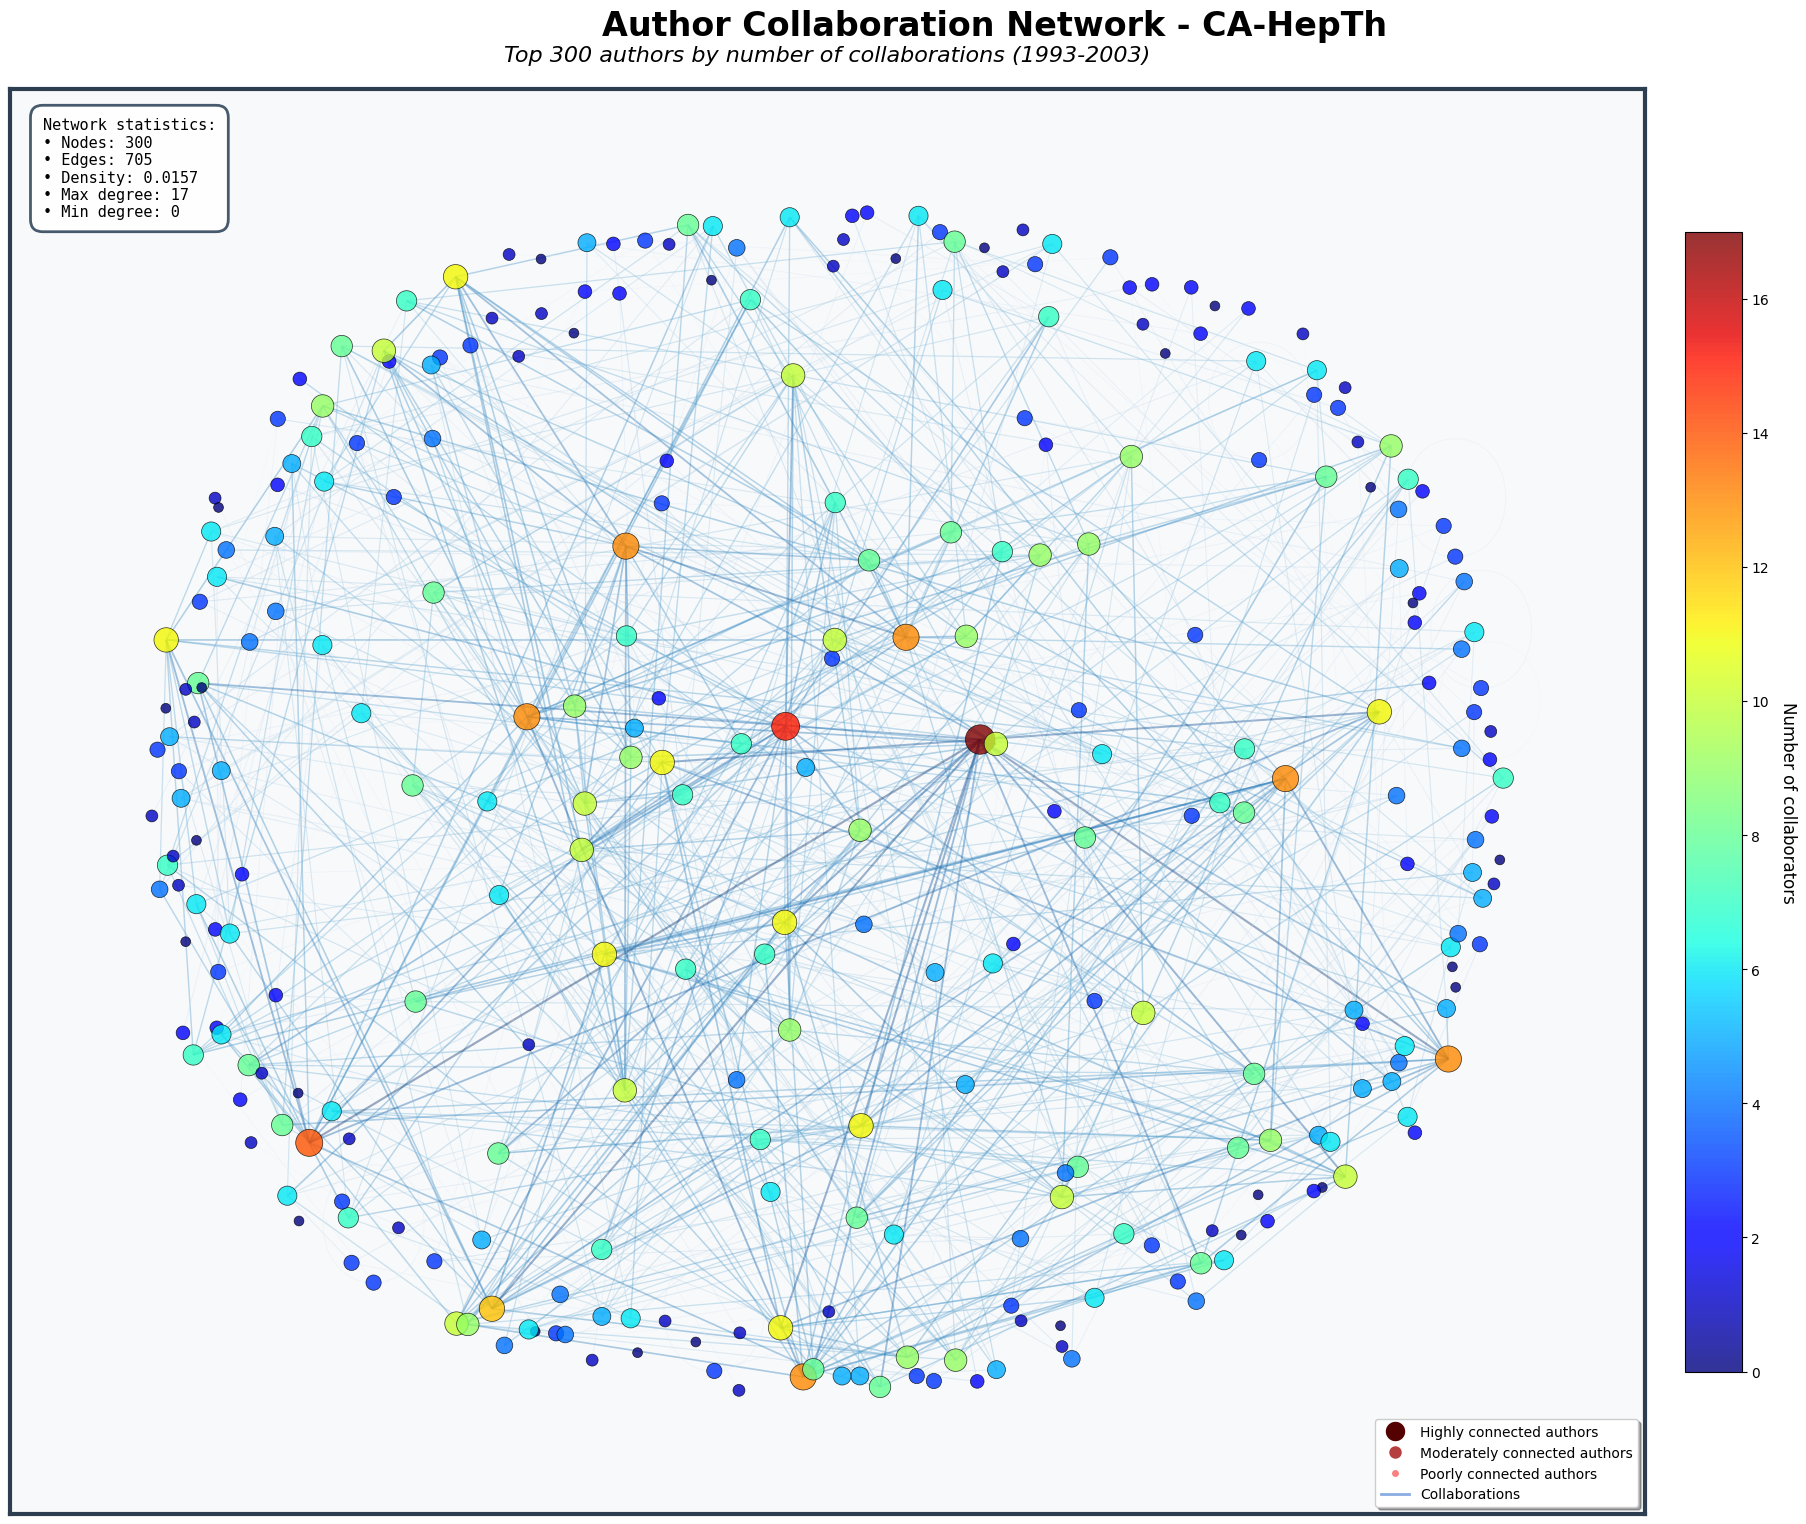

In [ ]:
def compute_edge_properties(H):
    """Computes visual properties of edges based on node degrees."""
    edge_colors = []
    edge_widths = []
    max_degree = max([H.degree[n] for n in H.nodes()])
    
    for edge in H.edges():
        # Color based on the sum of connected nodes' degrees
        degree_sum = H.degree[edge[0]] + H.degree[edge[1]]
        edge_colors.append(degree_sum)
        edge_widths.append(0.3 + (degree_sum / max_degree * 0.7))
    
    return edge_colors, edge_widths

def compute_node_properties(H):
    """Computes visual properties of nodes based on their degrees."""
    node_colors = [H.degree[node] for node in H.nodes()]
    max_degree = max([H.degree[n] for n in H.nodes()])
    min_degree = min([H.degree[n] for n in H.nodes()])
    
    # Node sizes proportional to degree with extended range
    node_sizes = [50 + (H.degree[node] - min_degree) / (max_degree - min_degree) * 400 
                  for node in H.nodes()]
    
    return node_colors, node_sizes, max_degree, min_degree

def draw_network_edges(H, pos, ax):
    """Draws network edges with computed colors and widths."""
    edge_colors, edge_widths = compute_edge_properties(H)
    
    nx.draw_networkx_edges(H, pos, 
                          edge_color=edge_colors, 
                          edge_cmap=plt.cm.Blues,
                          width=edge_widths,
                          alpha=0.4,
                          ax=ax)

def draw_network_nodes(H, pos, ax):
    """Draws network nodes with computed colors and sizes."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties(H)
    
    nodes = nx.draw_networkx_nodes(H, pos, 
                                  node_color=node_colors,
                                  node_size=node_sizes,
                                  cmap=plt.cm.jet,
                                  alpha=0.8,
                                  edgecolors='black',
                                  linewidths=0.5,
                                  ax=ax)
    
    return nodes, max_degree, min_degree

def add_titles_and_labels(fig, ax):
    """Adds main titles and subtitles."""
    fig.suptitle('Author Collaboration Network - CA-HepTh', 
                 fontsize=24, fontweight='bold', y=0.95)
    ax.set_title('Top 300 authors by number of collaborations (1993-2003)', 
                 fontsize=16, pad=20, style='italic')

def add_colorbar(nodes, ax):
    """Adds explanatory colorbar."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Number of collaborators', rotation=270, labelpad=20, fontsize=12)
    return cbar

def add_decorative_frame(ax):
    """Adds decorative frame around the plot."""
    for spine in ax.spines.values():
        spine.set_edgecolor('#2c3e50')
        spine.set_linewidth(3)

def add_statistics_box(H, max_degree, min_degree, ax):
    """Adds a box with network statistics."""
    textstr = f'''Network statistics:
• Nodes: {H.number_of_nodes():,}
• Edges: {H.number_of_edges():,}
• Density: {nx.density(H):.4f}
• Max degree: {max_degree}
• Min degree: {min_degree}'''

    props = dict(boxstyle='round,pad=0.8', facecolor='white', alpha=0.9, 
                 edgecolor='#34495e', linewidth=2)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')

# def add_custom_legend(ax):
#     """Adds custom legend with viridis colors."""
#     from matplotlib.lines import Line2D
    
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', markerfacecolor="#540101", 
#                markersize=15, label='Highly connected authors'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor="#b53f3f", 
#                markersize=10, label='Moderately connected authors'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor="#f98080", 
#                markersize=6, label='Poorly connected authors'),
#         Line2D([0], [0], color="#3E75CE", linewidth=2, alpha=0.6, label='Collaborations')
#     ]
    
#     ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
#               fancybox=True, shadow=True, fontsize=10)

def configure_axes(ax):
    """Configures axes and adds subtle grid."""
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.5)

def plot_collaboration_network(H, figsize=(20, 16)):
    """
    Main function to display collaboration network with all visual enhancements.
    
    Parameters:
    -----------
    H : networkx.Graph
        The subgraph to visualize
    figsize : tuple
        Figure size (width, height)
    """
    # Style configuration and figure creation
    plt.style.use('default')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    # Computing node positions with improved layout
    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)
    
    # Drawing the network
    draw_network_edges(H, pos, ax)
    nodes, max_degree, min_degree = draw_network_nodes(H, pos, ax)
    
    # Adding visual elements
    add_titles_and_labels(fig, ax)
    add_colorbar(nodes, ax)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    # add_custom_legend(ax)
    configure_axes(ax)
    
    # Layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    plt.show()

# Main function call
plot_collaboration_network(H)

<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

As we can expect from the dataset statistics, there are few authors who appear very central in the community and a vast majority with fewer collaborations. This power-law distribution is characteristic of scale-free networks, where a small number of highly connected "hubs" coexist with many nodes having only a few connections.

**Key Observations:**

| **Metric** | **Value** |
|------------|-----------|
| **Mean authors per paper** | 1.83 |
| **Standard deviation** | 1.20 |
| **Median (50th percentile)** | 2 authors |
| **75th percentile** | 3 authors |
| **Maximum** | 8 authors |

This indicates that:
- **Solo publications** are common (25% of papers have ≤1 author)
- **Small collaborations** dominate (75% of papers have ≤3 authors)
- **Large collaborations** are rare but present (max 8 authors per paper)

The visualization confirms this hierarchical structure, where highly connected authors (shown in bright yellow/green) act as **central hubs** linking different research subgroups, while the majority of authors (darker nodes) maintain more localized collaboration patterns within their immediate research communities.

<ul></div>

Other plot where instead of taking the 300 most important points we compute the most connected one and then take his neighboors, and finally neighboors of neighboors

Central node: Edward Witten


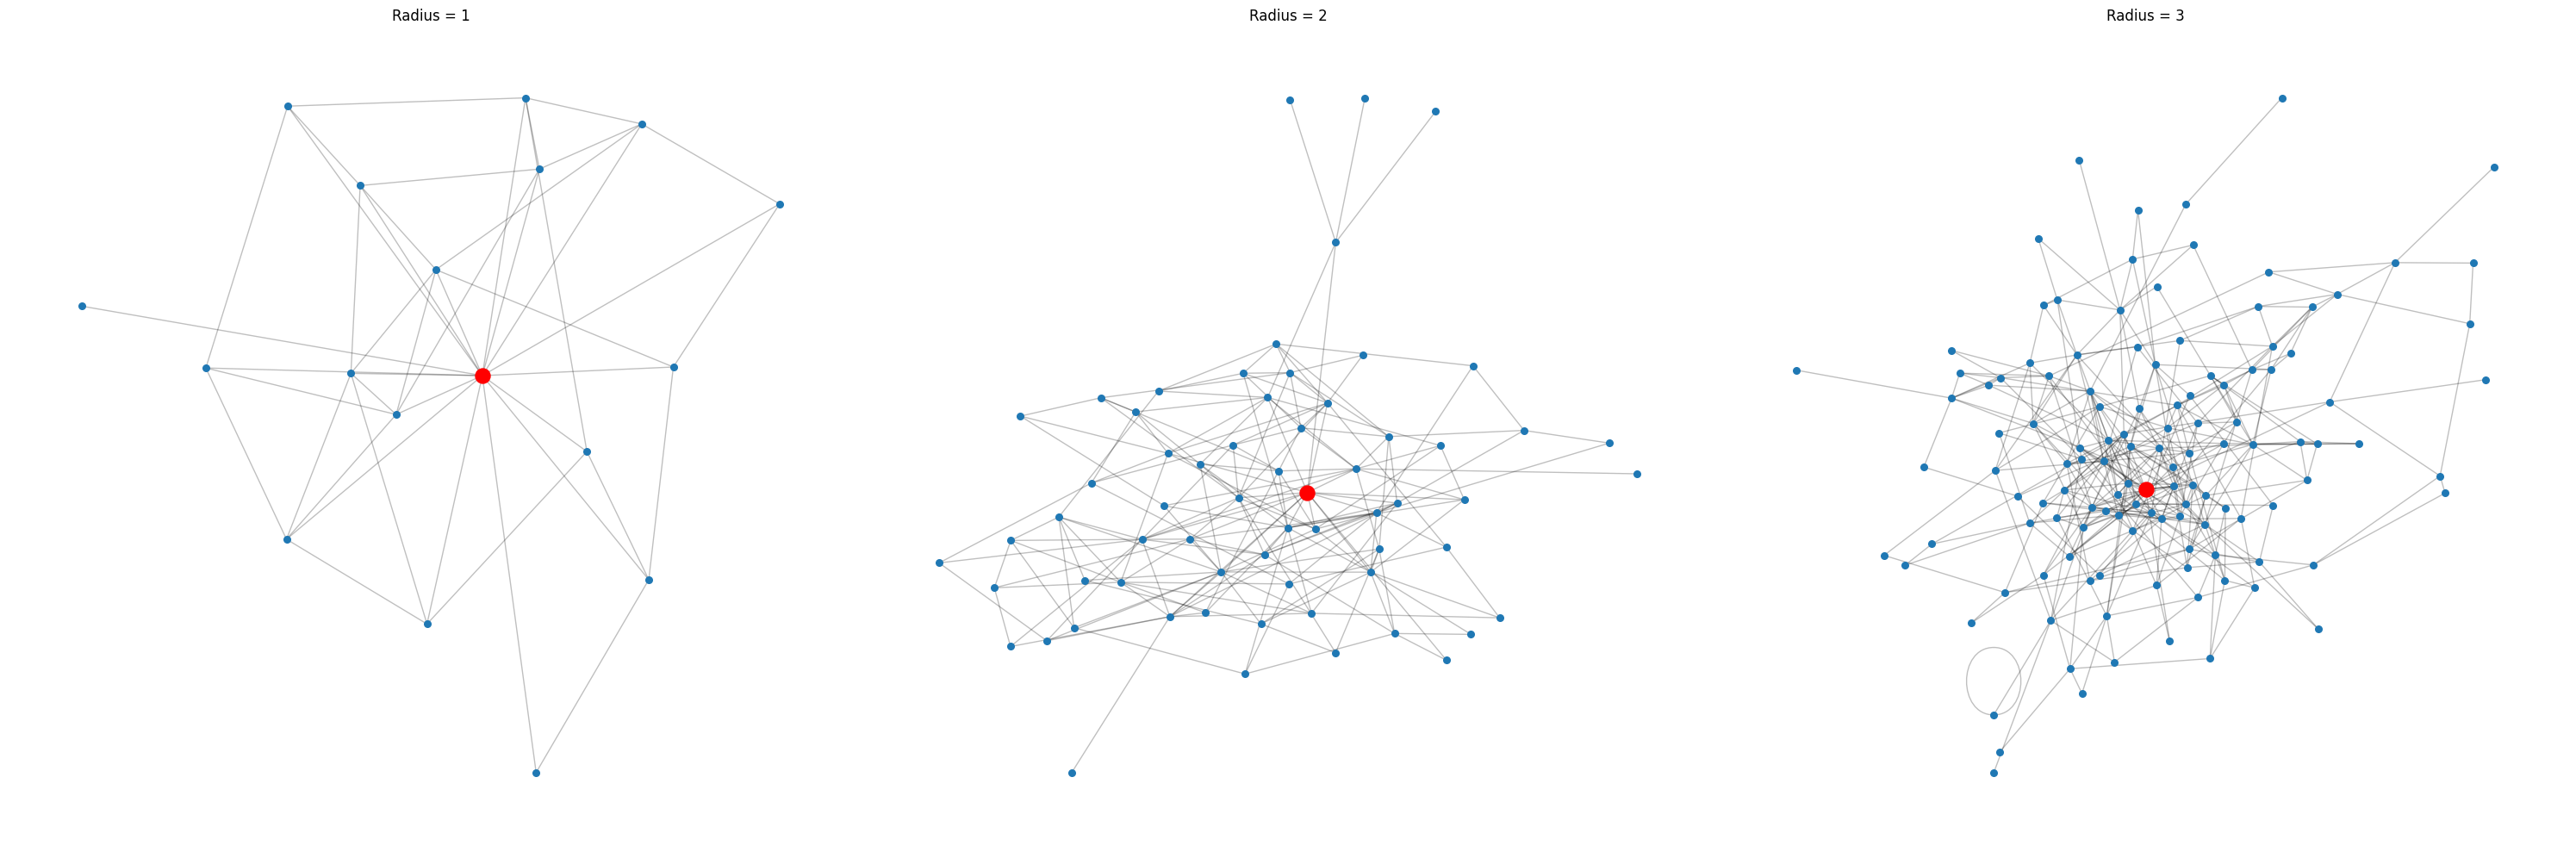

In [19]:
def show_graph_from_center(H, central_node, ax, title=None):
    pos = nx.spring_layout(H, seed=42)

    # dessiner sur l'axe donné
    nx.draw_networkx_nodes(H, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(H, pos, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(H, pos, nodelist=[central_node], node_size=150, node_color="red", ax=ax)

    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)

central_node = max(H.degree, key=lambda x: x[1])[0]
print("Central node:", central_node)

# une seule figure avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for ax, radius in zip(axes, [1, 2, 3]):
    Hc = nx.ego_graph(H, central_node, radius=radius)
    show_graph_from_center(Hc, central_node, ax, title=f"Radius = {radius}")

plt.tight_layout()
plt.show()


## Centrality Analysis

In a collaboration network like **CA-HepTh**, centrality measures help identify
not just *who collaborates the most*, but also *who connects scientific sub-communities*.

We will use two metrics describe **different roles**:
- Degree → *popularity / collaboration volume*
- Betweenness → *strategic position / connectivity across communities*

### Degree Centrality — *local visibility*
- Measures how many **distinct co-authors** an author has.
- High-degree nodes correspond to **highly active or prolific researchers**.
- Captures **local influence** within the collaboration network.

In [20]:
# Utiliser le graphe nettoyé pour calculer la centralité
deg_centrality = nx.degree_centrality(H)

# top 10 authors with highest degree centrality
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 auteurs par degré de centralité :")
for i, (author, centrality) in enumerate(top_degree, 1):
    print(f"{i}. {author}: {centrality:.6f}")

top_degree

Top 10 auteurs par degré de centralité :
1. Edward Witten: 0.056856
2. S. Ferrara: 0.050167
3. Andrew Strominger: 0.046823
4. Michael R. Douglas: 0.043478
5. E. Bergshoeff: 0.043478
6. K.S. Stelle: 0.043478
7. Jaemo Park: 0.043478
8. Jerome P. Gauntlett: 0.043478
9. Hirosi Ooguri: 0.043478
10. Shamit Kachru: 0.040134


[('Edward Witten', 0.056856187290969896),
 ('S. Ferrara', 0.05016722408026756),
 ('Andrew Strominger', 0.046822742474916385),
 ('Michael R. Douglas', 0.043478260869565216),
 ('E. Bergshoeff', 0.043478260869565216),
 ('K.S. Stelle', 0.043478260869565216),
 ('Jaemo Park', 0.043478260869565216),
 ('Jerome P. Gauntlett', 0.043478260869565216),
 ('Hirosi Ooguri', 0.043478260869565216),
 ('Shamit Kachru', 0.04013377926421405)]

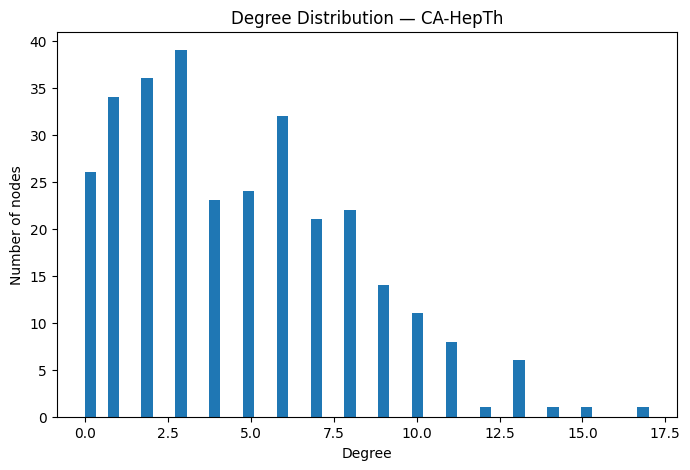

In [21]:
degrees = [d for _, d in H.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution — CA-HepTh")
plt.show()

### Betweenness Centrality — *structural brokerage*
- Measures how often a node lies on **shortest paths** between others.
- High-betweenness nodes act as **bridges between research groups**.
- Identifies **knowledge brokers** connecting subfields of theoretical physics.

In [22]:
bc = nx.betweenness_centrality(H, k=300, seed=42)

# top 10 authors with highest betweenness
top_betweenness = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness


[('A.A. Tseytlin', 0.12964745596245703),
 ('Gary T. Horowitz', 0.08992643645395453),
 ('T.R. Taylor', 0.06501109570754025),
 ('Soo-Jong Rey', 0.06443849547837988),
 ('Hirosi Ooguri', 0.06432681764180243),
 ('S. Ferrara', 0.0553765887386808),
 ('Klaus Behrndt', 0.047141135010629914),
 ('Dongsu Bak', 0.04409270328261645),
 ('E. Bergshoeff', 0.04405641455427959),
 ('S. Theisen', 0.04085938820491887)]




<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

### Degree vs Betweenness — Comparison

This scatter shows how **activity (degree)** relates to **structural position (betweenness)**.
- Nodes high in both = **central hubs linking major groups**
- High degree but low betweenness = **local stars** inside dense communities
- Low degree but high betweenness = **rare bridges** connecting otherwise distant areas

<ul></div>

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Visualization</h4>

## Community Detection

Beyond individual centrality measures, collaboration networks often exhibit a **modular structure**:
groups of authors who collaborate much more with each other than with the rest of the graph.

In this section, we explore two complementary notions of communities:

- **k-clique communities**: overlapping groups of authors forming dense clusters of size ≥ k
- **k-core decomposition**: nested shells of nodes that maintain at least k connections within the core

Together, they help reveal both **tight collaboration cliques** and **robust core communities** in the hep-th community.

</div>


### K-Core decomposition — structural robustness

Using the **k-core decomposition**, we identify nested shells of authors based on their **structural resilience** within the network. The k-core of a graph is the maximal subgraph where every node has at least k connections within that subgraph.

This analysis reveals:

- **Core researchers** (high k-core): authors who maintain many collaborations even when peripheral connections are removed,
- **Peripheral authors** (low k-core): researchers with fewer but potentially strategic connections,
- **Hierarchical structure**: how the collaboration network is organized in nested layers of connectivity.

Unlike clique-based methods, k-core decomposition is **non-overlapping** and focuses on **connectivity robustness** rather than dense clustering. Authors in higher k-cores represent the **structural backbone** of the hep-th collaboration network, maintaining connectivity even under network disruptions.

In [24]:
# K-Core decomposition analysis
from collections import Counter

# Remove self-loops and compute k-core decomposition
H_clean = H.copy()
H_clean.remove_edges_from(nx.selfloop_edges(H_clean))
kcore_communities = nx.core_number(H_clean)

# Analyze k-core distribution
core_values = list(kcore_communities.values())
core_distribution = Counter(core_values)
max_core, min_core = max(core_values), min(core_values)

print(f"K-core distribution: {min_core} to {max_core} ({len(set(core_values))} levels)")
print("Nodes per k-core level:")
for k in sorted(core_distribution.keys()):
    print(f"  k-core {k}: {core_distribution[k]} nodes")

# Show examples and identify core authors
sample_nodes = list(H.nodes())[:5]
print(f"\nExamples:")
for node in sample_nodes:
    print(f"  '{node}': k-core = {kcore_communities[node]}")

max_kcore_authors = [node for node, core in kcore_communities.items() if core == max_core]
print(f"\nCore authors (k-core {max_core}): {len(max_kcore_authors)} authors")
print(f"Examples: {max_kcore_authors[:5]}")

K-core distribution: 0 to 6 (7 levels)
Nodes per k-core level:
  k-core 0: 27 nodes
  k-core 1: 53 nodes
  k-core 2: 47 nodes
  k-core 3: 53 nodes
  k-core 4: 86 nodes
  k-core 5: 27 nodes
  k-core 6: 7 nodes

Examples:
  'Ruben Minasian': k-core = 4
  'Pei-Ming Ho': k-core = 3
  'Marcos Marino': k-core = 4
  'S. Theisen': k-core = 4
  'B. de Wit': k-core = 3

Core authors (k-core 6): 7 authors
Examples: ['M. Cvetic', 'H. Lu', 'G.W. Gibbons', 'C.N. Pope', 'M.J. Duff']


### k-Clique communities — percolation

Using the **k-clique percolation method** (here with k = 3), we identify overlapping groups of authors
who form dense collaboration clusters. These communities typically correspond to:

- research teams working closely on a specific subtopic,
- long-term collaboration groups around a few central senior authors,
- or tightly knit subfields inside the broader hep-th community.

Because the method is **overlapping**, a single author can belong to multiple k-clique communities,
reflecting the fact that senior researchers often connect several subgroups or projects.


In [ ]:
def add_kcore_communities(graph):
    """
    Ajoute les communautés k-core comme attributs des nœuds du graphe.
    
    Parameters:
    -----------
    graph : networkx.Graph
        Le graphe d'entrée
        
    Returns:
    --------
    networkx.Graph
        Une copie du graphe avec l'attribut 'kcore_community' ajouté à chaque nœud
    """
    # Créer une copie du graphe pour ne pas modifier l'original
    G_with_communities = graph.copy()
    
    # Supprimer les self-loops s'il y en a
    G_clean = G_with_communities.copy()
    G_clean.remove_edges_from(nx.selfloop_edges(G_clean))
    
    # Calculer les k-cores
    kcore_values = nx.core_number(G_clean)
    
    # Ajouter l'attribut k-core à chaque nœud
    for node in G_with_communities.nodes():
        G_with_communities.nodes[node]['kcore_community'] = kcore_values[node]
    
    return G_with_communities

# Tester la fonction
H_with_communities = add_kcore_communities(H)

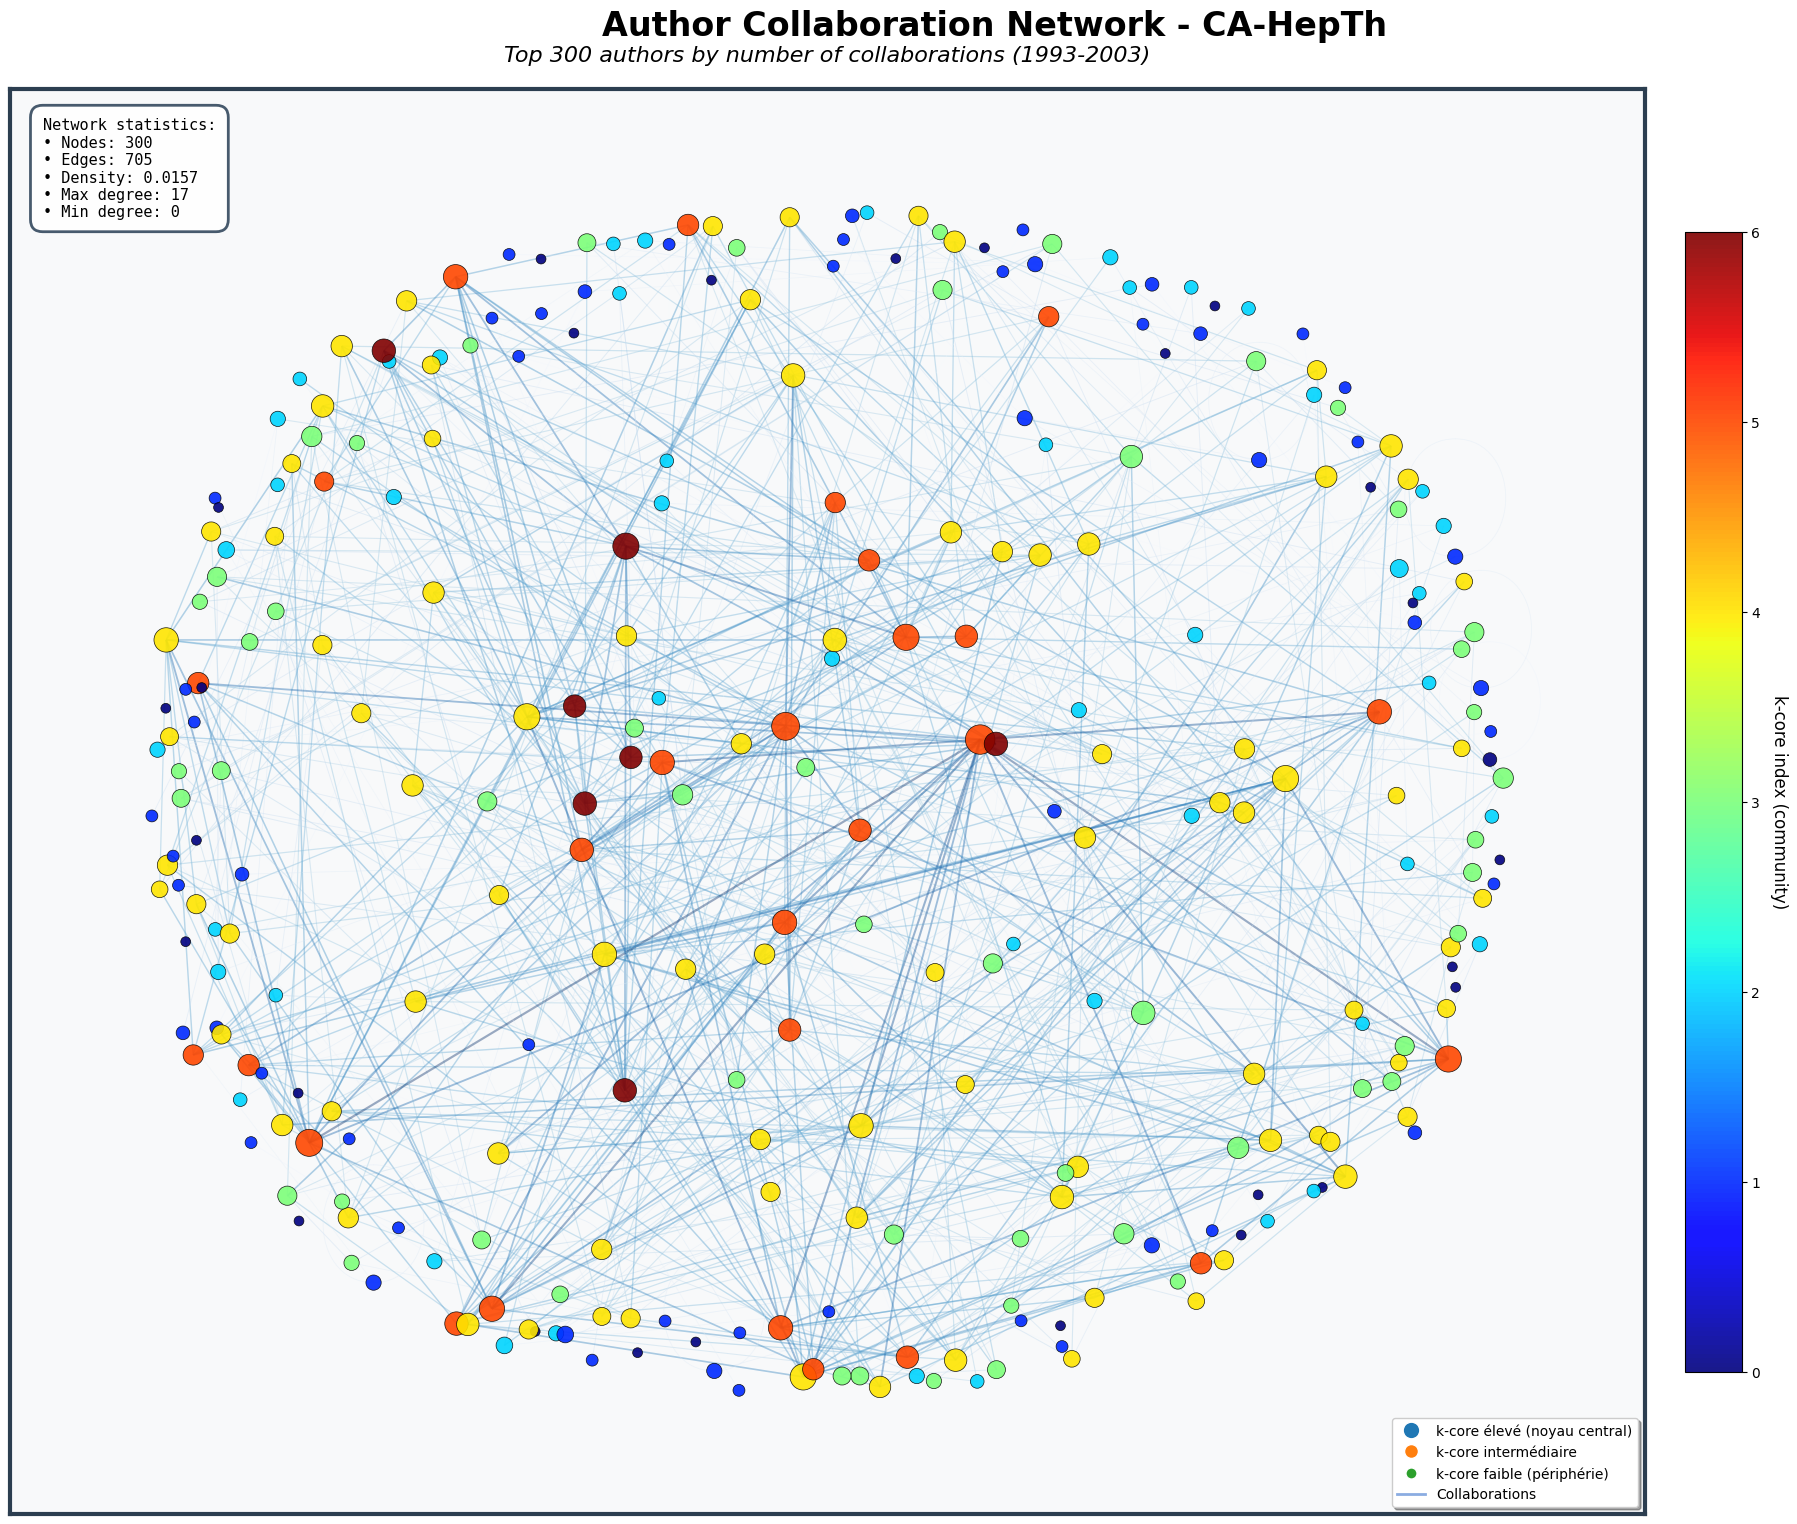

In [41]:
def compute_node_properties_by_community(H):
    """
    Utilise les degrés pour la taille des nœuds (comme avant)
    mais les couleurs viennent de l'attribut 'kcore_community'.
    """
    # tailles de nœuds via la fonction existante
    _, node_sizes, max_degree, min_degree = compute_node_properties(H)
    
    # couleurs = indice de communauté (k-core)
    node_colors = [H.nodes[n].get('kcore_community', 0) for n in H.nodes()]
    
    return node_colors, node_sizes, max_degree, min_degree

def draw_network_nodes_by_community(H, pos, ax):
    """Dessine les nœuds colorés par communauté k-core."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties_by_community(H)
    
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.jet,   # palette catégorielle sympa pour les communautés
        alpha=0.9,
        edgecolors='black',
        linewidths=0.5,
        ax=ax
    )
    
    return nodes, max_degree, min_degree

def add_colorbar_community(nodes, ax):
    """Colorbar pour les communautés k-core."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('k-core index (community)', rotation=270, labelpad=20, fontsize=12)
    return cbar

def add_custom_legend_community(ax):
    """Légende adaptée pour les communautés k-core."""
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor="#1f77b4",
               markersize=12, label='k-core élevé (noyau central)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor="#ff7f0e",
               markersize=10, label='k-core intermédiaire'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor="#2ca02c",
               markersize=8, label='k-core faible (périphérie)'),
        Line2D([0], [0], color="#3E75CE", linewidth=2, alpha=0.6, label='Collaborations')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
              fancybox=True, shadow=True, fontsize=10)

def plot_collaboration_network_by_community(H, figsize=(20, 16)):
    """
    Version de la visualisation où les couleurs représentent
    la communauté k-core de chaque nœud.
    """
    plt.style.use('default')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    # même layout qu'avant
    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)
    
    # arêtes : identiques
    draw_network_edges(H, pos, ax)
    
    # nœuds : mêmes tailles, mais couleurs = communauté
    nodes, max_degree, min_degree = draw_network_nodes_by_community(H, pos, ax)
    
    # titres / décor
    add_titles_and_labels(fig, ax)
    add_colorbar_community(nodes, ax)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    add_custom_legend_community(ax)   # ou add_custom_legend(ax) si tu préfères
    configure_axes(ax)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_collaboration_network_by_community(H_with_communities)



In [37]:
def add_kclique_communities(graph, k=3):
    """
    Ajoute, pour chaque nœud, la liste des cliques maximales de taille >= k
    auxquelles il appartient.

    Parameters
    ----------
    graph : networkx.Graph
        Le graphe d'entrée.
    k : int
        Taille minimale des cliques maximales retenues.

    Returns
    -------
    G_with_communities : networkx.Graph
        Copie du graphe avec l'attribut de nœud 'kclique_communities'
        (liste d'IDs de cliques maximales).
    cliques_filtered : list[list]
        Liste des cliques maximales (filtrées) utilisées, pour réutilisation
        ultérieure (visualisation, stats, etc.).
    """
    # Copie pour ne pas modifier l'original
    G_with_communities = graph.copy()
    
    # Nettoyage des self-loops
    G_clean = G_with_communities.copy()
    G_clean.remove_edges_from(nx.selfloop_edges(G_clean))

    # Trouver toutes les cliques maximales
    all_cliques = list(nx.find_cliques(G_clean))
    
    # Garder seulement celles de taille >= k
    cliques_filtered = [c for c in all_cliques if len(c) >= k]

    # Initialiser l'attribut sur tous les nœuds
    for node in G_with_communities.nodes():
        G_with_communities.nodes[node]["kclique_communities"] = []

    # Assigner les IDs de cliques aux nœuds
    for clique_id, clique in enumerate(cliques_filtered):
        for node in clique:
            G_with_communities.nodes[node]["kclique_communities"].append(clique_id)

    return G_with_communities, cliques_filtered

H_with_kcliques, cliques = add_kclique_communities(H, k=3)



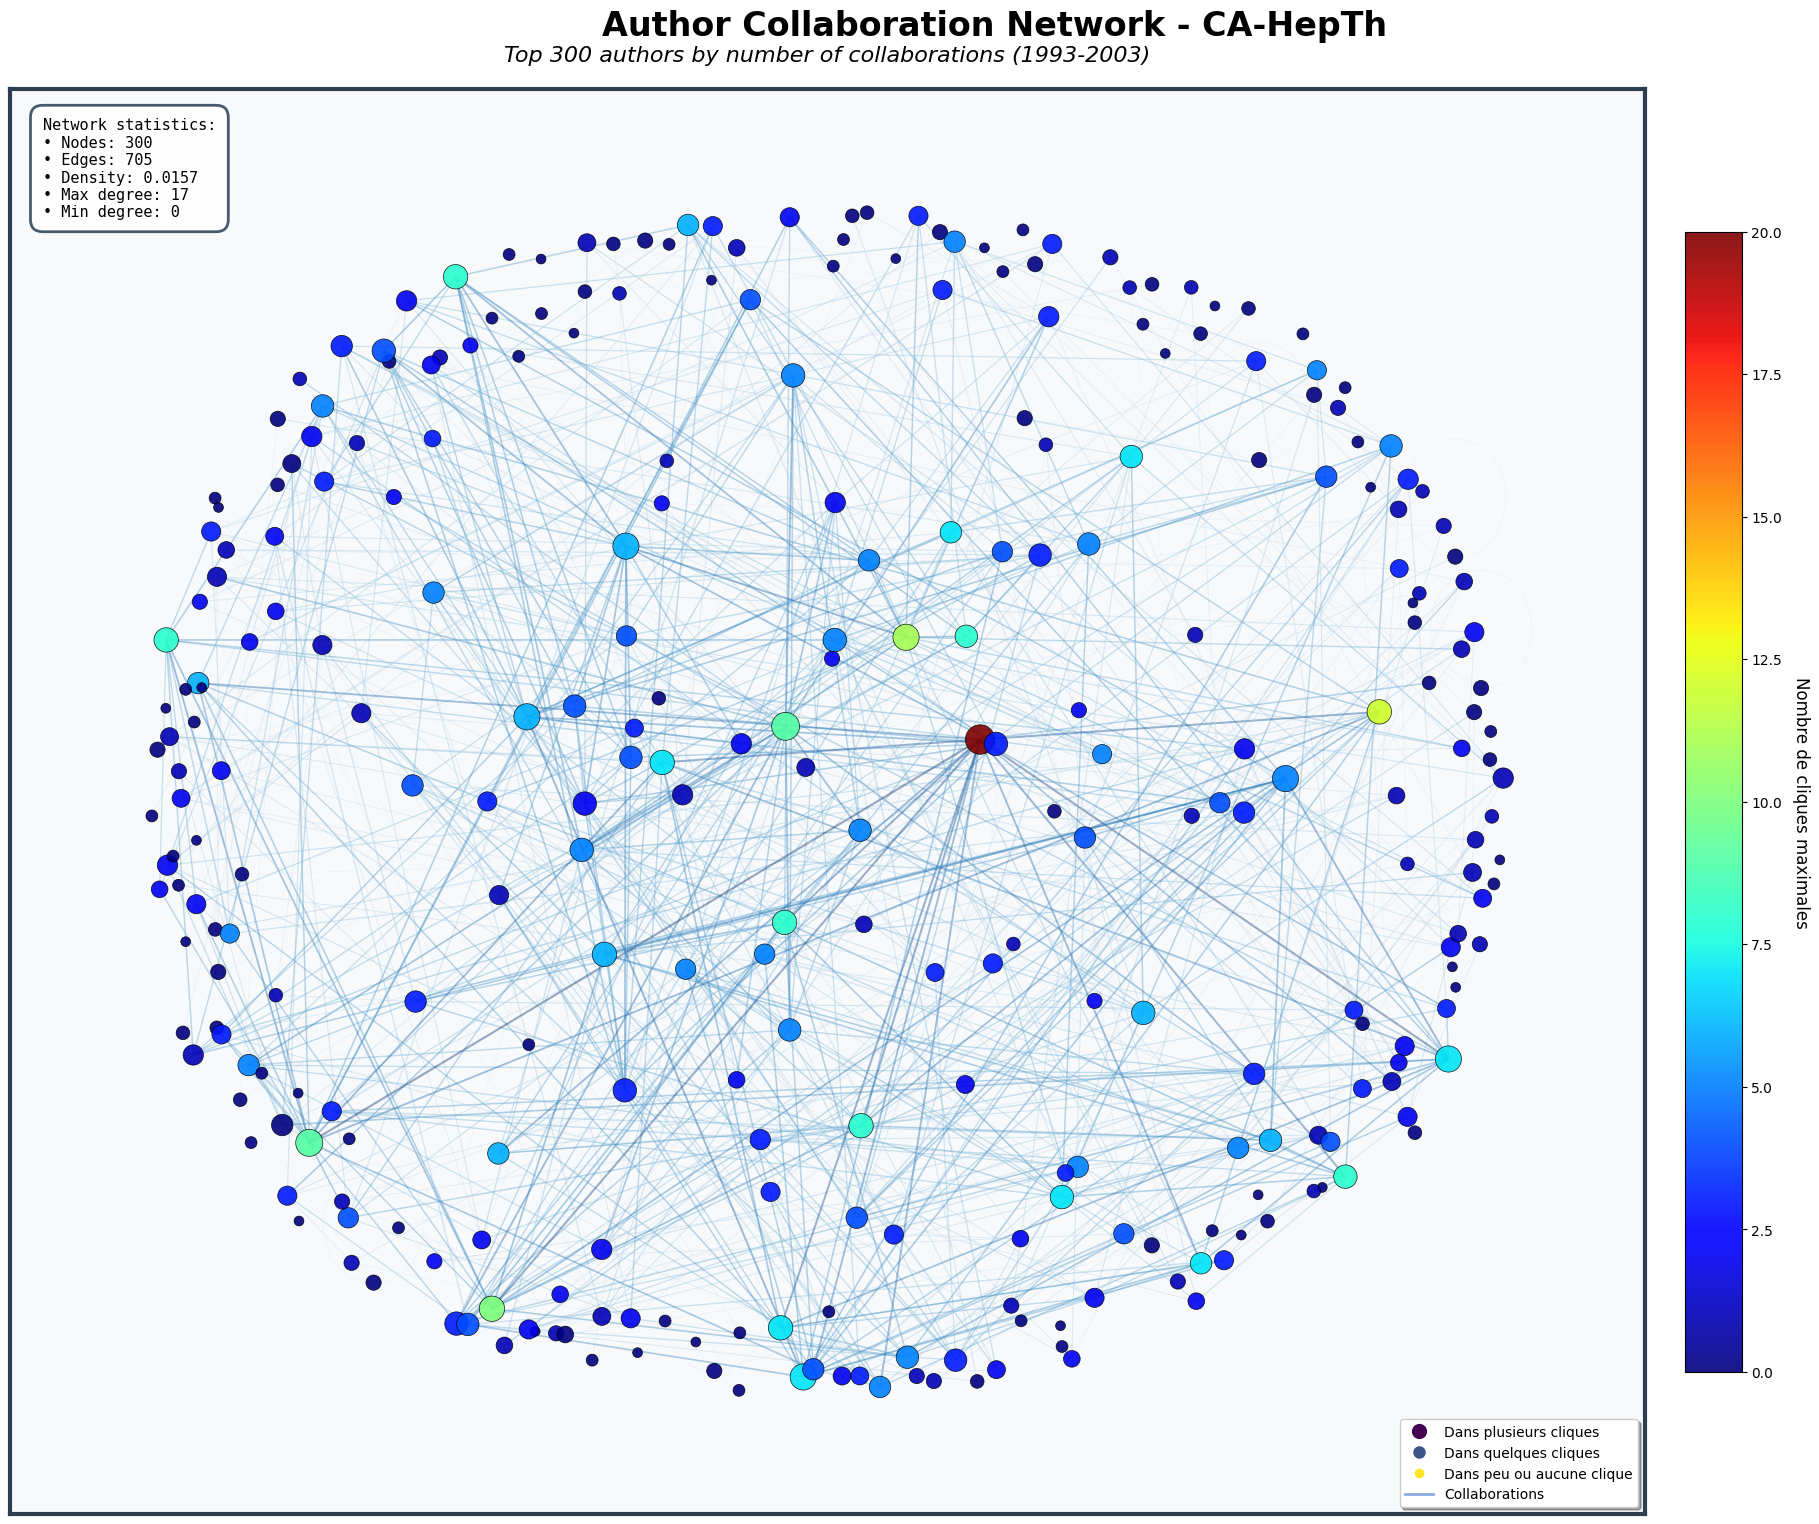

In [40]:
def compute_node_properties_by_kclique(H, clique_id=None):
    """
    Utilise les degrés pour la taille des nœuds (comme avant)
    mais les couleurs viennent de l'attribut 'kclique_communities'.

    - Si clique_id est None : couleur = nb de cliques auxquelles appartient le nœud
    - Sinon : couleur binaire (1 = dans la clique, 0 = hors de la clique)
    """
    # tailles de nœuds via la fonction existante
    _, node_sizes, max_degree, min_degree = compute_node_properties(H)
    
    if clique_id is None:
        # couleur = nombre de cliques
        node_colors = [
            len(H.nodes[n].get('kclique_communities', []))
            for n in H.nodes()
        ]
    else:
        # couleur = 1 si le nœud est dans la clique sélectionnée, 0 sinon
        node_colors = [
            1 if clique_id in H.nodes[n].get('kclique_communities', []) else 0
            for n in H.nodes()
        ]
    
    return node_colors, node_sizes, max_degree, min_degree

def draw_network_nodes_by_kclique(H, pos, ax, clique_id=None):
    """Dessine les nœuds colorés en fonction des k-cliques."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties_by_kclique(H, clique_id=clique_id)
    
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.jet,   # même style que ta version k-core
        alpha=0.9,
        edgecolors='black',
        linewidths=0.5,
        ax=ax
    )
    
    return nodes, max_degree, min_degree

def add_colorbar_kclique(nodes, ax, clique_id=None):
    """Colorbar pour les communautés k-cliques."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    if clique_id is None:
        cbar.set_label("Nombre de cliques maximales", rotation=270, labelpad=20, fontsize=12)
    else:
        cbar.set_label(f"Appartenance à la clique #{clique_id}", rotation=270, labelpad=20, fontsize=12)
    return cbar

def add_custom_legend_kclique(ax, clique_id=None):
    """Légende adaptée pour les communautés k-cliques."""
    from matplotlib.lines import Line2D
    
    if clique_id is None:
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#440154",
                   markersize=12, label='Dans plusieurs cliques'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#3b528b",
                   markersize=10, label='Dans quelques cliques'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#fde725",
                   markersize=8, label='Dans peu ou aucune clique'),
            Line2D([0], [0], color="#3E75CE", linewidth=2, alpha=0.6, label='Collaborations')
        ]
    else:
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#ff7f0e",
                   markersize=12, label=f'Membres de la clique #{clique_id}'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor="#bbbbbb",
                   markersize=8, label='Hors de cette clique'),
            Line2D([0], [0], color="#3E75CE", linewidth=2, alpha=0.6, label='Collaborations')
        ]
    
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
              fancybox=True, shadow=True, fontsize=10)

def plot_collaboration_network_by_kclique(H, figsize=(20, 16), clique_id=None):
    """
    Visualisation où les couleurs représentent :
    - soit le nombre de cliques maximales par nœud (clique_id=None)
    - soit une clique particulière (clique_id = id d’une clique)
    """
    plt.style.use('default')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    # même layout qu'avant
    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)
    
    # arêtes : identiques
    draw_network_edges(H, pos, ax)
    
    # nœuds : tailles = degré, couleurs = k-cliques
    nodes, max_degree, min_degree = draw_network_nodes_by_kclique(H, pos, ax, clique_id=clique_id)
    
    # titres / décor
    add_titles_and_labels(fig, ax)
    add_colorbar_kclique(nodes, ax, clique_id=clique_id)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    add_custom_legend_kclique(ax, clique_id=clique_id)
    configure_axes(ax)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_collaboration_network_by_kclique(H_with_kcliques)

